## 2016-2020 NBA CNN Predictor
In this notebook we will look at usiing a convolutional neural network to determine which team wins a game. In order to do this we will use the same concept for predicting images. A pixel in our data will be a 1x2 pixel which will encompass a matchup of a player against another by positiona and % of itme in that position. The stride of the block will be something around 1x2 as well in order to move by matchups. 

### Data Source
For data source we are utilizing basketball-reference, we have downloaded the outcomes of every game (except playoffs) for the campaigns of 2016-2017 to 2019-2020, so three seasons. The other two files of data we have are the players per 36 stats of the year. This may not be the right way, we would probably want the per 36 to that game in the season. 

- outcomes2.csv: contains the games files and the outcomes. This way we can easily load the data from the games.
- pbp: Play by play data containing the % of playing time by position for each player.
- per36.csv: Per 36 stats for a season

Installing necessary packages and importing functions

In [119]:
#!pip install tensorflow pandas keras sklearn pickle multiprocess

In [1]:
import pandas as pd
import os
# comment following line if the user would like to use tensorflow backend.
os.environ['KERAS_BACKEND'] = 'theano'
import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler,PowerTransformer, Normalizer
from sklearn.model_selection import train_test_split
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2D, MaxPooling2D, Conv1D
import pickle
import multiprocess

#### Loading Pickle Files
If you dont want to wait for the things before here is a way to load the pickles of all the data read and fomatted as wanted.

In [2]:
filename = 'season12_20.pickle'
def read_pickle(filename):
    infile = open(filename,'rb')
    new_dict = pickle.load(infile)
    infile.close()
    
    return new_dict
try:
    
    seasons = read_pickle(filename)
    len(seasons['labels'])
except:
    seasons = {}

### Creating Matchup Matrix
Following function will get the data from the file and format it to get into the model

We may want to divide the data into offense and defense and try to have the same amount of columns for each. This was thought in order to have a pixel of offense, defense, and other and make the string work that way. (this was before i removed columns that have the * on them for less features). Maybe we can add them back in the future.

- **Defense** - ORB, DRB, STL, BLK, *PF
- **Offense** - PTS, AST, TOV, FT%, 3P%, 2P%
- **Other**   - *Weight, *Height, Position%, *MP


In [5]:
# Universal variables
point_guards = None
shooting_guards = None
small_forwards = None
power_forwards = None
centers = None
scaler = None
all_data = None

# Some names chagne through out the year so we have the latest name available to convert
name_changes = {
    "2020": {
        'Kevin Porter':'Kevin Porter Jr.',
        'Michael Porter': 'Michael Porter Jr.',
        'Mohamed Bamba': 'Mo Bamba',
        'Tim Hardaway': 'Tim Hardaway Jr.',
        'Troy Brown': 'Troy Brown Jr.',
        'Kelly Oubre': 'Kelly Oubre Jr.',
        'Derrick Jones': 'Derrick Jones Jr.',
        'Glenn Robinson': 'Glenn Robinson III',
        'Marvin Bagley': 'Marvin Bagley III',
        'Frank Mason': 'Frank Mason III',
        'Wenyen Gabriel': 'Frank Mason III',
        'Jaren Jackson': 'Jaren Jackson Jr.',
        'Wendell Carter': 'Wendell Carter Jr.',
        'Dennis Smith': 'Dennis Smith Jr.',
        'Larry Nance': 'Larry Nance Jr.',
        'Taurean Waller-Prince':'Taurean Prince',
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'Gary Trent': 'Gary Trent Jr.',
        'Gary Payton': 'Gary Payton II',
        'James Webb': 'James Webb III',
        'Jakob Pöltl': "Jakob Poeltl"
    },
    "2019": {
        'Mohamed Bamba': 'Mo Bamba',
        'Tim Hardaway': 'Tim Hardaway Jr.',
        'Troy Brown': 'Troy Brown Jr.',
        'Kelly Oubre': 'Kelly Oubre Jr.',
        'Derrick Jones': 'Derrick Jones Jr.',
        'Glenn Robinson': 'Glenn Robinson III',
        'Marvin Bagley': 'Marvin Bagley III',
        'Frank Mason': 'Frank Mason III',
        'Wenyen Gabriel': 'Frank Mason III',
        'Jaren Jackson': 'Jaren Jackson Jr.',
        'Wendell Carter': 'Wendell Carter Jr.',
        'Dennis Smith': 'Dennis Smith Jr.',
        'Larry Nance': 'Larry Nance Jr.',
        'Taurean Waller-Prince':'Taurean Prince',
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'Gary Trent': 'Gary Trent Jr.',
        'Gary Payton': 'Gary Payton II',
        'Jakob Pöltl': "Jakob Poeltl"
    },
    "2018": {
        'Mohamed Bamba': 'Mo Bamba',
        'Tim Hardaway': 'Tim Hardaway Jr.',
        'Troy Brown': 'Troy Brown Jr.',
        'Kelly Oubre': 'Kelly Oubre Jr.',
        'Derrick Jones': 'Derrick Jones Jr.',
        'Glenn Robinson': 'Glenn Robinson III',
        'Marvin Bagley': 'Marvin Bagley III',
        'Frank Mason': 'Frank Mason III',
        'Wenyen Gabriel': 'Frank Mason III',
        'Jaren Jackson': 'Jaren Jackson Jr.',
        'Wendell Carter': 'Wendell Carter Jr.',
        'Dennis Smith': 'Dennis Smith Jr.',
        'Larry Nance': 'Larry Nance Jr.',
        'Taurean Waller-Prince':'Taurean Prince',
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'Gary Trent': 'Gary Trent Jr.',
        'Gary Payton': 'Gary Payton II',
        'James Webb': 'James Webb III',

    },
    "2017": {
        'Mohamed Bamba': 'Mo Bamba',
        'Tim Hardaway': 'Tim Hardaway Jr.',
        'Troy Brown': 'Troy Brown Jr.',
        'Kelly Oubre': 'Kelly Oubre Jr.',
        'Derrick Jones': 'Derrick Jones Jr.',
        'Glenn Robinson': 'Glenn Robinson III',
        'Marvin Bagley': 'Marvin Bagley III',
        'Frank Mason': 'Frank Mason III',
        'Wenyen Gabriel': 'Frank Mason III',
        'Jaren Jackson': 'Jaren Jackson Jr.',
        'Wendell Carter': 'Wendell Carter Jr.',
        'Dennis Smith': 'Dennis Smith Jr.',
        'Larry Nance': 'Larry Nance Jr.',
        'Taurean Waller-Prince':'Taurean Prince',
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'Gary Trent': 'Gary Trent Jr.',
        'Gary Payton': 'Gary Payton II',
        'James Webb': 'James Webb III'
    },
    "2016": {
        'Mohamed Bamba': 'Mo Bamba',
        'Tim Hardaway': 'Tim Hardaway Jr.',
        'Troy Brown': 'Troy Brown Jr.',
        'Kelly Oubre': 'Kelly Oubre Jr.',
        'Derrick Jones': 'Derrick Jones Jr.',
        'Glenn Robinson': 'Glenn Robinson III',
        'Marvin Bagley': 'Marvin Bagley III',
        'Frank Mason': 'Frank Mason III',
        'Wenyen Gabriel': 'Frank Mason III',
        'Jaren Jackson': 'Jaren Jackson Jr.',
        'Wendell Carter': 'Wendell Carter Jr.',
        'Dennis Smith': 'Dennis Smith Jr.',
        'Larry Nance': 'Larry Nance Jr.',
        'Taurean Waller-Prince':'Taurean Prince',
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'Gary Trent': 'Gary Trent Jr.',
        'Gary Payton': 'Gary Payton II',
        'James Webb': 'James Webb III'
    },
    "2015": {
        'Mohamed Bamba': 'Mo Bamba',
        'Tim Hardaway': 'Tim Hardaway Jr.',
        'Troy Brown': 'Troy Brown Jr.',
        'Kelly Oubre': 'Kelly Oubre Jr.',
        'Derrick Jones': 'Derrick Jones Jr.',
        'Glenn Robinson': 'Glenn Robinson III',
        'Marvin Bagley': 'Marvin Bagley III',
        'Frank Mason': 'Frank Mason III',
        'Wenyen Gabriel': 'Frank Mason III',
        'Jaren Jackson': 'Jaren Jackson Jr.',
        'Wendell Carter': 'Wendell Carter Jr.',
        'Dennis Smith': 'Dennis Smith Jr.',
        'Larry Nance': 'Larry Nance Jr.',
        'Taurean Waller-Prince':'Taurean Prince',
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'Gary Trent': 'Gary Trent Jr.',
        'Gary Payton': 'Gary Payton II',
        'James Webb': 'James Webb III',
        'Jeffery Taylor':'Jeff Taylor',
        'Luigi Datome': 'Gigi Datome',
        'Vítor Faverani':'Vítor Luiz Faverani',
        'Larry Drew':'Larry Drew II'
    },
    "2014": {
        'Mohamed Bamba': 'Mo Bamba',
        'Tim Hardaway': 'Tim Hardaway Jr.',
        'Troy Brown': 'Troy Brown Jr.',
        'Kelly Oubre': 'Kelly Oubre Jr.',
        'Derrick Jones': 'Derrick Jones Jr.',
        'Glenn Robinson': 'Glenn Robinson III',
        'Marvin Bagley': 'Marvin Bagley III',
        'Frank Mason': 'Frank Mason III',
        'Wenyen Gabriel': 'Frank Mason III',
        'Jaren Jackson': 'Jaren Jackson Jr.',
        'Wendell Carter': 'Wendell Carter Jr.',
        'Dennis Smith': 'Dennis Smith Jr.',
        'Larry Nance': 'Larry Nance Jr.',
        'Taurean Waller-Prince':'Taurean Prince',
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'Gary Trent': 'Gary Trent Jr.',
        'Gary Payton': 'Gary Payton II',
        'James Webb': 'James Webb III',
        'Jeffery Taylor':'Jeff Taylor',
        'Luigi Datome': 'Gigi Datome',
        'Vítor Faverani':'Vítor Luiz Faverani',
        'Larry Drew':'Larry Drew II',
        'Glen Rice': 'Glen Rice Jr.'
    },
    "2013": {
        'Mohamed Bamba': 'Mo Bamba',
        'Tim Hardaway': 'Tim Hardaway Jr.',
        'Troy Brown': 'Troy Brown Jr.',
        'Kelly Oubre': 'Kelly Oubre Jr.',
        'Derrick Jones': 'Derrick Jones Jr.',
        'Glenn Robinson': 'Glenn Robinson III',
        'Marvin Bagley': 'Marvin Bagley III',
        'Frank Mason': 'Frank Mason III',
        'Wenyen Gabriel': 'Frank Mason III',
        'Jaren Jackson': 'Jaren Jackson Jr.',
        'Wendell Carter': 'Wendell Carter Jr.',
        'Dennis Smith': 'Dennis Smith Jr.',
        'Larry Nance': 'Larry Nance Jr.',
        'Taurean Waller-Prince':'Taurean Prince',
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'Gary Trent': 'Gary Trent Jr.',
        'Gary Payton': 'Gary Payton II',
        'James Webb': 'James Webb III',
        'Jeffery Taylor':'Jeff Taylor',
        'Luigi Datome': 'Gigi Datome',
        'Vítor Faverani':'Vítor Luiz Faverani',
        'Larry Drew':'Larry Drew II',
        'Glen Rice': 'Glen Rice Jr.'
    },
    "2012": {
        'Mohamed Bamba': 'Mo Bamba',
        'Tim Hardaway': 'Tim Hardaway Jr.',
        'Troy Brown': 'Troy Brown Jr.',
        'Kelly Oubre': 'Kelly Oubre Jr.',
        'Derrick Jones': 'Derrick Jones Jr.',
        'Glenn Robinson': 'Glenn Robinson III',
        'Marvin Bagley': 'Marvin Bagley III',
        'Frank Mason': 'Frank Mason III',
        'Wenyen Gabriel': 'Frank Mason III',
        'Jaren Jackson': 'Jaren Jackson Jr.',
        'Wendell Carter': 'Wendell Carter Jr.',
        'Dennis Smith': 'Dennis Smith Jr.',
        'Larry Nance': 'Larry Nance Jr.',
        'Taurean Waller-Prince':'Taurean Prince',
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'Gary Trent': 'Gary Trent Jr.',
        'Gary Payton': 'Gary Payton II',
        'James Webb': 'James Webb III',
        'Jeffery Taylor':'Jeff Taylor',
        'Luigi Datome': 'Gigi Datome',
        'Vítor Faverani':'Vítor Luiz Faverani',
        'Larry Drew':'Larry Drew II',
        'Glen Rice': 'Glen Rice Jr.'
    },
    "2011": {
        'Walt Lemon': 'Walt Lemon Jr.',
        'Gary Trent': 'Gary Trent Jr.',
        'Gary Payton': 'Gary Payton II',
        'James Webb': 'James Webb III',
        'Jeffery Taylor':'Jeff Taylor',
        'Luigi Datome': 'Gigi Datome',
        'Vítor Faverani':'Vítor Luiz Faverani',
        'Larry Drew':'Larry Drew II',
        'Glen Rice': 'Glen Rice Jr.',
        'Didier Ilunga-Mbenga':'D.J. Mbenga'
    },
    "2010": {
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'Gary Trent': 'Gary Trent Jr.',
        'Gary Payton': 'Gary Payton II',
        'James Webb': 'James Webb III',
        'Jeffery Taylor':'Jeff Taylor',
        'Luigi Datome': 'Gigi Datome',
        'Vítor Faverani':'Vítor Luiz Faverani',
        'Larry Drew':'Larry Drew II',
        'Glen Rice': 'Glen Rice Jr.',
        'Didier Ilunga-Mbenga':'D.J. Mbenga'
    },
    "2009": {
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'Gary Trent': 'Gary Trent Jr.',
        'Gary Payton': 'Gary Payton II',
        'James Webb': 'James Webb III',
        'Jeffery Taylor':'Jeff Taylor',
        'Luigi Datome': 'Gigi Datome',
        'Vítor Faverani':'Vítor Luiz Faverani',
        'Larry Drew':'Larry Drew II',
        'Glen Rice': 'Glen Rice Jr.',
        'Didier Ilunga-Mbenga':'D.J. Mbenga'
    },
    "2008": {
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'Gary Trent': 'Gary Trent Jr.',
        'Gary Payton': 'Gary Payton II',
        'James Webb': 'James Webb III',
        'Jeffery Taylor':'Jeff Taylor',
        'Luigi Datome': 'Gigi Datome',
        'Vítor Faverani':'Vítor Luiz Faverani',
        'Larry Drew':'Larry Drew II',
        'Glen Rice': 'Glen Rice Jr.',
        'Didier Ilunga-Mbenga':'D.J. Mbenga'
    },
    "2007": {
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'Gary Trent': 'Gary Trent Jr.',
        'James Webb': 'James Webb III',
        'Jeffery Taylor':'Jeff Taylor',
        'Luigi Datome': 'Gigi Datome',
        'Vítor Faverani':'Vítor Luiz Faverani',
        'Larry Drew':'Larry Drew II',
        'Glen Rice': 'Glen Rice Jr.',
        'Didier Ilunga-Mbenga':'D.J. Mbenga'
    },
    "2006": {
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'Gary Trent': 'Gary Trent Jr.',
        'James Webb': 'James Webb III',
        'Jeffery Taylor':'Jeff Taylor',
        'Luigi Datome': 'Gigi Datome',
        'Vítor Faverani':'Vítor Luiz Faverani',
        'Larry Drew':'Larry Drew II',
        'Glen Rice': 'Glen Rice Jr.',
        'Didier Ilunga-Mbenga':'D.J. Mbenga'
    },
    "2005": {
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'Gary Trent': 'Gary Trent Jr.',
        'James Webb': 'James Webb III',
        'Jeffery Taylor':'Jeff Taylor',
        'Luigi Datome': 'Gigi Datome',
        'Vítor Faverani':'Vítor Luiz Faverani',
        'Larry Drew':'Larry Drew II',
        'Glen Rice': 'Glen Rice Jr.',
        'Didier Ilunga-Mbenga':'D.J. Mbenga'
    },
    "2004": {
        'Mohamed Bamba': 'Mo Bamba',
        'Tim Hardaway': 'Tim Hardaway Jr.',
        'Troy Brown': 'Troy Brown Jr.',
        'Kelly Oubre': 'Kelly Oubre Jr.',
        'Derrick Jones': 'Derrick Jones Jr.',
        'Marvin Bagley': 'Marvin Bagley III',
        'Frank Mason': 'Frank Mason III',
        'Wenyen Gabriel': 'Frank Mason III',
        'Jaren Jackson': 'Jaren Jackson Jr.',
        'Wendell Carter': 'Wendell Carter Jr.',
        'Dennis Smith': 'Dennis Smith Jr.',
        'Larry Nance': 'Larry Nance Jr.',
        'Taurean Waller-Prince':'Taurean Prince',
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'James Webb': 'James Webb III',
        'Jeffery Taylor':'Jeff Taylor',
        'Luigi Datome': 'Gigi Datome',
        'Vítor Faverani':'Vítor Luiz Faverani',
        'Larry Drew':'Larry Drew II',
        'Didier Ilunga-Mbenga':'D.J. Mbenga'
    },
    "2003": {
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'James Webb': 'James Webb III',
        'Jeffery Taylor':'Jeff Taylor',
        'Luigi Datome': 'Gigi Datome',
        'Vítor Faverani':'Vítor Luiz Faverani',
        'Larry Drew':'Larry Drew II',
        'Didier Ilunga-Mbenga':'D.J. Mbenga'
    },
    "2002": {
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'James Webb': 'James Webb III',
        'Jeffery Taylor':'Jeff Taylor',
        'Luigi Datome': 'Gigi Datome',
        'Vítor Faverani':'Vítor Luiz Faverani',
        'Larry Drew':'Larry Drew II',
        'Didier Ilunga-Mbenga':'D.J. Mbenga'
    },
    "2001": {
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'James Webb': 'James Webb III',
        'Jeffery Taylor':'Jeff Taylor',
        'Luigi Datome': 'Gigi Datome',
        'Vítor Faverani':'Vítor Luiz Faverani',
        'Larry Drew':'Larry Drew II',
        'Didier Ilunga-Mbenga':'D.J. Mbenga'
    },
    "2000": {
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'James Webb': 'James Webb III',
        'Jeffery Taylor':'Jeff Taylor',
        'Luigi Datome': 'Gigi Datome',
        'Vítor Faverani':'Vítor Luiz Faverani',
        'Larry Drew':'Larry Drew II',
        'Didier Ilunga-Mbenga':'D.J. Mbenga'
    },
    "1999": {
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'James Webb': 'James Webb III',
        'Jeffery Taylor':'Jeff Taylor',
        'Luigi Datome': 'Gigi Datome',
        'Vítor Faverani':'Vítor Luiz Faverani',
        'Larry Drew':'Larry Drew II',
        'Didier Ilunga-Mbenga':'D.J. Mbenga'
    },
    "1998": {
        'Nenê Hilário': 'Nenê',
        'Walt Lemon': 'Walt Lemon Jr.',
        'James Webb': 'James Webb III',
        'Jeffery Taylor':'Jeff Taylor',
        'Luigi Datome': 'Gigi Datome',
        'Vítor Faverani':'Vítor Luiz Faverani',
        'Larry Drew':'Larry Drew II',
        'Didier Ilunga-Mbenga':'D.J. Mbenga'
    },
    "1997": {
        'Nenê Hilário': 'Nenê'
    },
    "1996": {
        'Nenê Hilário': 'Nenê'
    },
    "1995": {
        'Nenê Hilário': 'Nenê'
    },
    "1994": {
        'Nenê Hilário': 'Nenê'
    },
    "1993": {
        'Nenê Hilário': 'Nenê'
    },
    "1992": {
        'Nenê Hilário': 'Nenê'
    },
    "1991": {
        'Nenê Hilário': 'Nenê'
    },
    "1990": {
        'Nenê Hilário': 'Nenê'
    },
    "1989": {
        'Nenê Hilário': 'Nenê'
    },
    "1988": {
        'Nenê Hilário': 'Nenê'
    },
    "1987": {
        'Nenê Hilário': 'Nenê'
    },
    "1986": {
        'Nenê Hilário': 'Nenê'
    },
    "1985": {
        'Nenê Hilário': 'Nenê'
    },
    "1984": {
        'Nenê Hilário': 'Nenê'
    },
    "1983": {
        'Nenê Hilário': 'Nenê'
    },
    "1982": {
        'Nenê Hilário': 'Nenê'
    },
    "1981": {
        'Nenê Hilário': 'Nenê'
    },
    "1980": {
        'Nenê Hilário': 'Nenê'
    },
    "1979": {
        'Nenê Hilário': 'Nenê'
    },
    "1978": {
        'Nenê Hilário': 'Nenê'
    },
    "1977": {
        'Nenê Hilário': 'Nenê'
    },
    "1976": {
        'Nenê Hilário': 'Nenê'
    },
    "1975": {
        'Nenê Hilário': 'Nenê'
    }
    
}

def read_pickle(filename):
    infile = open(filename,'rb')
    new_dict = pickle.load(infile)
    infile.close()
    
    return new_dict

def p2f(x):
    '''
        Fucntion that will convert the data of percentage from string to float.
    '''
    temp = []
    for value in x:
        if isinstance(value, float) or not "%" in value:
            temp.append(value)
        else:
            temp.append(float(value.strip('%'))/100)
        
    return temp

# changes to the data queried made this a thing now.
def new_name_col(data):
    return data.split('\\')[0].replace("*","")

# Checking if players play against each other by position adn how much percentage of the time it is.
def check_positions(player1, player2):
    global point_guards, shooting_guards, small_forwards, power_forwards, centers
    mathcup = False
    percentage = {
        player1:0,
        player2:0
    }
    
    if len(point_guards[(point_guards["names"] == player1) | (point_guards["names"] == player2)]) == 2:
        for index,row in point_guards[(point_guards["names"] == player1) | (point_guards["names"] == player2)].iterrows():
            mathcup = True
            percentage[row.names] = percentage[row.names]+row["PG%"]
            
    if len(shooting_guards[(shooting_guards["names"] == player1) | (shooting_guards["names"] == player2)]) == 2:
        for index,row in shooting_guards[(shooting_guards["names"] == player1) | (shooting_guards["names"] == player2)].iterrows():
            mathcup = True
            percentage[row.names] = percentage[row.names]+row["SG%"]
    
    if len(small_forwards[(small_forwards["names"] == player1) | (small_forwards["names"] == player2)]) == 2:
        for index,row in small_forwards[(small_forwards["names"] == player1) | (small_forwards["names"] == player2)].iterrows():
            mathcup = True
            percentage[row.names] = percentage[row.names]+row["SF%"]
            
    if len(power_forwards[(power_forwards["names"] == player1) | (power_forwards["names"] == player2)]) == 2:
        for index,row in power_forwards[(power_forwards["names"] == player1) | (power_forwards["names"] == player2)].iterrows():
            mathcup = True
            percentage[row.names] = percentage[row.names]+row["PF%"
                                                             ]
    if len(centers[(centers["names"] == player1) | (centers["names"] == player2)]) == 2:
        for index,row in centers[(centers["names"] == player1) | (centers["names"] == player2)].iterrows():
            mathcup = True
            percentage[row.names] = percentage[row.names]+row["C%"]
    
    return mathcup, percentage

# percentage multiplier for DF
def mult_percentage(row, percentage):
    return row*percentage

# generate matchups matrix
def matchups(home, away, year, idx):
    global scaler, all_data
    image = []
    
    print(idx, end=" ")
    
    for player1 in home:
        for player2 in away:
            matchup,percentages = check_positions(player1,player2)
            
            try:
                temp1 = all_data[(all_data["names"] == player1) & (all_data["season"] == year)].drop(["names", "Player", "season"], axis=1).apply(mult_percentage,percentage = percentages[player1]).fillna(0).values.tolist()[0]
            except:
                print("Not found - ",player1)
                temp1 = [0 for value in range(len(all_data.columns)-3)]
                
            if matchup:
                try:
                    temp2 = all_data[(all_data["names"] == player2) & (all_data["season"] == year)].drop(["names", "Player","season"], axis=1).apply(mult_percentage,percentage = percentages[player2]).fillna(0).values.tolist()[0]
                except:
                    print("Not found - ",player2)
                    temp2 = [0 for value in range(len(all_data.columns)-3)]
            
            else:
                temp2 = [0 for value in temp1]

            temp1.append(1)
            temp2.append(0)

            image.append(temp1)
            image.append(temp2)
                
    return image

# Name changes to array
def change_name(value, year):
    global name_changes
    if value in list(name_changes[year].keys()):
        return name_changes[year][value]
    return value

def get_data(year):
    '''
        Function to load the data to the notebook and format it.
        
        Param:
            - year: year of the season
            - season: the season year in format of ex. 2018-19
    '''    
    games = read_pickle("games/"+year+"/season"+year+".pickle")
    outcomes = read_pickle("games/"+year+"/outcomes"+year+".pickle")
    #games['season'] = [year for x in range(len(games))]
    per36 = pd.read_csv("games/"+year+"/per36.csv")
    per36['season'] = [year for x in range(len(per36))]
    # maybe later we can use dimensions again. meaning player height and weight.
    # dim = pd.read_csv("dimensions.csv", index_col=0)
    pbp = pd.read_csv("games/"+year+"/pbp.csv", index_col=0)
    pbp['season'] = [year for x in range(len(pbp))]
    print(len(games))
        
    return games, per36, pbp, outcomes

def format_data(games, per36, pbp, outcomes):
    global point_guards, shooting_guards, small_forwards, power_forwards, centers, scaler, all_data
    # This is an average for the full season. Later we can use the correct team to pbp for better accuracy.
    # Basically what it means a player moved/got traded from a team.
    pbp["merged"] = pbp["Player"]+pbp["season"]
    tot_players = pbp[pbp.Tm == 'TOT']
    
    # just keeping the TOT.
    pbp = pbp[~(pbp.merged.isin(tot_players.merged))].append(tot_players).reset_index(drop=True)
    pbp.drop(["merged"], axis=1, inplace=True)
    
    # columns we want 
    columns = ['Player', 'PG%', 'SG%', 'SF%', 'PF%', 'C%', 'season']
    pbp = pbp[columns]
    
    # format percent column to a float
    pbp = pbp.fillna("0.0%").apply(p2f)
    
    # Getting minutes per game. this will help in ordering the data to have the highest playing players.
    per36['MPG'] = per36.MP/per36.G
    
    # Same problemn of TOT of player movement. Fixing it below.
    per36["merged"] = per36["Player"]+per36["season"]
    tot_players = per36[per36.Tm == 'TOT']
    per36 = per36[~(per36.merged.isin(tot_players.merged))].append(tot_players).reset_index(drop=True)
    per36.drop(["merged"], axis=1, inplace=True)
    
    # Offense.
    columns = "PTS, AST, TOV, FT%, 3P%, 2P%, season".split(", ")
    columns.append("Player")
    offense = per36[columns]
    
    # Defense
    columns = "ORB, DRB, STL, BLK, season".split(", ")
    columns.append("Player")
    defense = per36[columns].fillna(0)
    
    # Other - omitting dimensions
    #other = pd.merge(pbp, dim, left_on="Player", right_on="Player")
    other = pd.merge(pbp, per36[['Player', 'MPG', "season"]], left_on=["Player","season"], right_on=["Player","season"])
    
    # The following couple lines will create a list of player by positions they play 
    # in order to create the matchup matrix later on
    centers = other[other["C%"] > 0 ]
    centers["names"] = centers.Player.apply(new_name_col)
    
    power_forwards = other[other["PF%"] > 0 ]
    power_forwards["names"] = power_forwards.Player.apply(new_name_col)
    
    small_forwards = other[other["SF%"] > 0 ]
    small_forwards["names"] = small_forwards.Player.apply(new_name_col)
    
    shooting_guards = other[other["SG%"] > 0 ]
    shooting_guards["names"] = shooting_guards.Player.apply(new_name_col)
    
    point_guards = other[other["PG%"] > 0 ]
    point_guards["names"] = point_guards.Player.apply(new_name_col)
    
    # Merging offense, defense and other data.
    all_data = pd.merge(other, offense, left_on=["Player","season"], right_on=["Player","season"])
    all_data = pd.merge(all_data, defense, left_on=["Player","season"], right_on=["Player","season"])
    
    # Formating names to match the position matrix. Also dropping MPG (kinda not needed. Why did we creae it again?)
    all_data["names"] = all_data.Player.apply(new_name_col)
    all_data.drop(["MPG"], axis=1, inplace=True)
    
    # Getting labels
    temp_df = pd.DataFrame(outcomes)
    
    labels = list(temp_df.outcome)
    process_pool = multiprocess.Pool(multiprocess.cpu_count() - 1)
    
    # Building the pseudo images from the matchups.
    matchup_builder = []
    for idx, file in temp_df.iterrows():
        away = games[idx]['away']
        away['Starters'] = away['Starters'].apply(change_name, year=file.season)
        home = games[idx]['home']
        home['Starters'] = home['Starters'].apply(change_name, year=file.season)
        print(file)
        home.replace('Did Not Play',0,inplace=True)
        away.replace('Did Not Play',0,inplace=True)
        
        matchup_builder.append((home['Starters'][:9], away['Starters'][:9], file.season, idx))
        
    images = process_pool.starmap(matchups, matchup_builder)
        
    return images,labels

In [6]:
# "2020,2019-2020","2019,2018-19","2018,2017-18","2017,2016-17","2016,2015-16",
# "2015,2014-15","2014,2013-14","2013,2012-13","2012,2011-12","2011,2010-11",
# "2010,2009-10", "2009,2008-09","2008,2007-08","2007,2006-07","2006,2005-06",
# "2005,2004-05","2004,2003-04","2002,2001-02","2000,1999-00","1999,1998-99"
# "1998,1997-98","1997,1996-97","1996,1995-96","1995,1994-95","1994,1993-94"
# "1993,1992-93","1992,1991-92","1991,1990-91","1990,1989-90","1989,1988-89"
# "1988,1987-88","1987,1986-87","1986,1985-86","1985,1984-85","1984,1983-84",
# "1983,1983-84","1982,1983-84","1981,1983-84","1980,1983-84"
years = ["1979","1978","1977","1976","1975"]
games = None
per36 = None
pbp = None 
outcomes = None

for season in years:
    temp1, temp2, temp3, temp4 = get_data(season)
    
    for row in range(len(temp4)):
        temp4[row]['season'] = season
    if games is None:
        games = temp1
        per36 = temp2
        pbp = temp3
        outcomes=temp4
    else:
        games = games + temp1
        per36 = per36.append(temp2)
        pbp = pbp.append(temp3)
        outcomes = outcomes + temp4
print("Finished")

856
774
544
525
495
Finished


In [7]:
%%time
images, labels = format_data(games, per36, pbp, outcomes)
print("Finished")

<ipython-input-5-862b54b0a77e>:637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  centers["names"] = centers.Player.apply(new_name_col)
<ipython-input-5-862b54b0a77e>:640: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  power_forwards["names"] = power_forwards.Player.apply(new_name_col)
<ipython-input-5-862b54b0a77e>:646: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

outcome       1
game          0
season     1979
Name: 0, dtype: object
outcome       0
game          1
season     1979
Name: 1, dtype: object
outcome       1
game          4
season     1979
Name: 2, dtype: object
outcome       1
game          5
season     1979
Name: 3, dtype: object
outcome       1
game          6
season     1979
Name: 4, dtype: object
outcome       1
game          7
season     1979
Name: 5, dtype: object
outcome       0
game          8
season     1979
Name: 6, dtype: object
outcome       1
game          9
season     1979
Name: 7, dtype: object
outcome       1
game         11
season     1979
Name: 8, dtype: object
outcome       0
game         12
season     1979
Name: 9, dtype: object
outcome       0
game         14
season     1979
Name: 10, dtype: object
outcome       1
game         15
season     1979
Name: 11, dtype: object
outcome       0
game         16
season     1979
Name: 12, dtype: object
outcome       1
game         18
season     1979
Name: 13, dtype: object
ou

outcome       1
game        170
season     1979
Name: 152, dtype: object
outcome       0
game        171
season     1979
Name: 153, dtype: object
outcome       1
game        172
season     1979
Name: 154, dtype: object
outcome       1
game        173
season     1979
Name: 155, dtype: object
outcome       0
game        174
season     1979
Name: 156, dtype: object
outcome       1
game        175
season     1979
Name: 157, dtype: object
outcome       0
game        176
season     1979
Name: 158, dtype: object
outcome       1
game        177
season     1979
Name: 159, dtype: object
outcome       1
game        178
season     1979
Name: 160, dtype: object
outcome       0
game        180
season     1979
Name: 161, dtype: object
outcome       0
game        181
season     1979
Name: 162, dtype: object
outcome       1
game        182
season     1979
Name: 163, dtype: object
outcome       1
game        183
season     1979
Name: 164, dtype: object
outcome       1
game        187
season     1979
Nam

outcome       1
game        345
season     1979
Name: 311, dtype: object
outcome       1
game        346
season     1979
Name: 312, dtype: object
outcome       0
game        347
season     1979
Name: 313, dtype: object
outcome       0
game        348
season     1979
Name: 314, dtype: object
outcome       1
game        349
season     1979
Name: 315, dtype: object
outcome       1
game        350
season     1979
Name: 316, dtype: object
outcome       0
game        351
season     1979
Name: 317, dtype: object
outcome       1
game        352
season     1979
Name: 318, dtype: object
outcome       0
game        353
season     1979
Name: 319, dtype: object
outcome       1
game        355
season     1979
Name: 320, dtype: object
outcome       1
game        357
season     1979
Name: 321, dtype: object
outcome       0
game        358
season     1979
Name: 322, dtype: object
outcome       1
game        359
season     1979
Name: 323, dtype: object
outcome       0
game        360
season     1979
Nam

Name: 468, dtype: object
outcome       1
game        519
season     1979
Name: 469, dtype: object
outcome       1
game        520
season     1979
Name: 470, dtype: object
outcome       0
game        521
season     1979
Name: 471, dtype: object
outcome       1
game        522
season     1979
Name: 472, dtype: object
outcome       0
game        523
season     1979
Name: 473, dtype: object
outcome       1
game        524
season     1979
Name: 474, dtype: object
outcome       1
game        525
season     1979
Name: 475, dtype: object
outcome       1
game        526
season     1979
Name: 476, dtype: object
outcome       1
game        527
season     1979
Name: 477, dtype: object
outcome       1
game        528
season     1979
Name: 478, dtype: object
outcome       1
game        529
season     1979
Name: 479, dtype: object
outcome       0
game        530
season     1979
Name: 480, dtype: object
outcome       0
game        531
season     1979
Name: 481, dtype: object
outcome       1
game      

Name: 629, dtype: object
outcome       1
game        693
season     1979
Name: 630, dtype: object
outcome       1
game        694
season     1979
Name: 631, dtype: object
outcome       0
game        695
season     1979
Name: 632, dtype: object
outcome       1
game        697
season     1979
Name: 633, dtype: object
outcome       1
game        698
season     1979
Name: 634, dtype: object
outcome       0
game        699
season     1979
Name: 635, dtype: object
outcome       0
game        700
season     1979
Name: 636, dtype: object
outcome       1
game        701
season     1979
Name: 637, dtype: object
outcome       0
game        702
season     1979
Name: 638, dtype: object
outcome       1
game        703
season     1979
Name: 639, dtype: object
outcome       1
game        704
season     1979
Name: 640, dtype: object
outcome       1
game        705
season     1979
Name: 641, dtype: object
outcome       0
game        706
season     1979
Name: 642, dtype: object
outcome       0
game      

outcome       0
game        827
season     1979
Name: 756, dtype: object
outcome       1
game        828
season     1979
Name: 757, dtype: object
outcome       1
game        830
season     1979
Name: 758, dtype: object
outcome       1
game        832
season     1979
Name: 759, dtype: object
outcome       1
game        833
season     1979
Name: 760, dtype: object
outcome       1
game        835
season     1979
Name: 761, dtype: object
outcome       0
game        836
season     1979
Name: 762, dtype: object
outcome       0
game        837
season     1979
Name: 763, dtype: object
outcome       0
game        838
season     1979
Name: 764, dtype: object
outcome       1
game        839
season     1979
Name: 765, dtype: object
outcome       1
game        840
season     1979
Name: 766, dtype: object
outcome       0
game        841
season     1979
Name: 767, dtype: object
outcome       1
game        842
season     1979
Name: 768, dtype: object
outcome       1
game        844
season     1979
Nam

Name: 878, dtype: object
outcome       0
game         27
season     1978
Name: 879, dtype: object
outcome       1
game         28
season     1978
Name: 880, dtype: object
outcome       0
game         29
season     1978
Name: 881, dtype: object
outcome       0
game         30
season     1978
Name: 882, dtype: object
outcome       1
game         31
season     1978
Name: 883, dtype: object
outcome       0
game         32
season     1978
Name: 884, dtype: object
outcome       1
game         33
season     1978
Name: 885, dtype: object
outcome       1
game         34
season     1978
Name: 886, dtype: object
outcome       0
game         35
season     1978
Name: 887, dtype: object
outcome       1
game         36
season     1978
Name: 888, dtype: object
outcome       1
game         37
season     1978
Name: 889, dtype: object
outcome       1
game         38
season     1978
Name: 890, dtype: object
outcome       1
game         39
season     1978
Name: 891, dtype: object
outcome       1
game      

Name: 991, dtype: object
outcome       1
game        164
season     1978
Name: 992, dtype: object
outcome       1
game        165
season     1978
Name: 993, dtype: object
outcome       0
game        166
season     1978
Name: 994, dtype: object
outcome       0
game        167
season     1978
Name: 995, dtype: object
outcome       1
game        168
season     1978
Name: 996, dtype: object
outcome       1
game        169
season     1978
Name: 997, dtype: object
outcome       1
game        171
season     1978
Name: 998, dtype: object
outcome       1
game        172
season     1978
Name: 999, dtype: object
outcome       0
game        173
season     1978
Name: 1000, dtype: object
outcome       1
game        174
season     1978
Name: 1001, dtype: object
outcome       1
game        175
season     1978
Name: 1002, dtype: object
outcome       1
game        177
season     1978
Name: 1003, dtype: object
outcome       0
game        178
season     1978
Name: 1004, dtype: object
outcome       1
game 

Name: 1175, dtype: object
outcome       1
game        391
season     1978
Name: 1176, dtype: object
outcome       0
game        392
season     1978
Name: 1177, dtype: object
outcome       0
game        393
season     1978
Name: 1178, dtype: object
outcome       1
game        394
season     1978
Name: 1179, dtype: object
outcome       0
game        396
season     1978
Name: 1180, dtype: object
outcome       1
game        397
season     1978
Name: 1181, dtype: object
outcome       1
game        398
season     1978
Name: 1182, dtype: object
outcome       1
game        399
season     1978
Name: 1183, dtype: object
outcome       0
game        401
season     1978
Name: 1184, dtype: object
outcome       0
game        402
season     1978
Name: 1185, dtype: object
outcome       0
game        403
season     1978
Name: 1186, dtype: object
outcome       1
game        404
season     1978
Name: 1187, dtype: object
outcome       1
game        405
season     1978
Name: 1188, dtype: object
outcome     

Name: 1335, dtype: object
outcome       1
game        576
season     1978
Name: 1336, dtype: object
outcome       1
game        577
season     1978
Name: 1337, dtype: object
outcome       0
game        578
season     1978
Name: 1338, dtype: object
outcome       1
game        579
season     1978
Name: 1339, dtype: object
outcome       0
game        580
season     1978
Name: 1340, dtype: object
outcome       1
game        581
season     1978
Name: 1341, dtype: object
outcome       1
game        582
season     1978
Name: 1342, dtype: object
outcome       0
game        583
season     1978
Name: 1343, dtype: object
outcome       1
game        585
season     1978
Name: 1344, dtype: object
outcome       1
game        586
season     1978
Name: 1345, dtype: object
outcome       1
game        587
season     1978
Name: 1346, dtype: object
outcome       1
game        588
season     1978
Name: 1347, dtype: object
outcome       0
game        589
season     1978
Name: 1348, dtype: object
outcome     

Name: 1507, dtype: object
outcome       1
game        789
season     1978
Name: 1508, dtype: object
outcome       0
game        790
season     1978
Name: 1509, dtype: object
outcome       1
game        791
season     1978
Name: 1510, dtype: object
outcome       1
game        792
season     1978
Name: 1511, dtype: object
outcome       1
game        793
season     1978
Name: 1512, dtype: object
outcome       1
game        795
season     1978
Name: 1513, dtype: object
outcome       1
game        796
season     1978
Name: 1514, dtype: object
outcome       0
game        797
season     1978
Name: 1515, dtype: object
outcome       1
game        798
season     1978
Name: 1516, dtype: object
outcome       1
game        799
season     1978
Name: 1517, dtype: object
outcome       1
game        800
season     1978
Name: 1518, dtype: object
outcome       0
game        801
season     1978
Name: 1519, dtype: object
outcome       1
game        802
season     1978
Name: 1520, dtype: object
outcome     

Name: 1657, dtype: object
outcome       1
game         51
season     1977
Name: 1658, dtype: object
outcome       0
game         52
season     1977
Name: 1659, dtype: object
outcome       1
game         53
season     1977
Name: 1660, dtype: object
outcome       1
game         55
season     1977
Name: 1661, dtype: object
outcome       1
game         56
season     1977
Name: 1662, dtype: object
outcome       0
game         57
season     1977
Name: 1663, dtype: object
outcome       1
game         61
season     1977
Name: 1664, dtype: object
outcome       1
game         62
season     1977
Name: 1665, dtype: object
outcome       1
game         64
season     1977
Name: 1666, dtype: object
outcome       1
game         65
season     1977
Name: 1667, dtype: object
outcome       1
game         68
season     1977
Name: 1668, dtype: object
outcome       1
game         69
season     1977
Name: 1669, dtype: object
outcome       0
game         70
season     1977
Name: 1670, dtype: object
outcome     

Name: 1809, dtype: object
outcome       0
game        308
season     1977
Name: 1810, dtype: object
outcome       0
game        309
season     1977
Name: 1811, dtype: object
outcome       1
game        310
season     1977
Name: 1812, dtype: object
outcome       1
game        311
season     1977
Name: 1813, dtype: object
outcome       0
game        313
season     1977
Name: 1814, dtype: object
outcome       0
game        315
season     1977
Name: 1815, dtype: object
outcome       1
game        316
season     1977
Name: 1816, dtype: object
outcome       1
game        317
season     1977
Name: 1817, dtype: object
outcome       1
game        318
season     1977
Name: 1818, dtype: object
outcome       1
game        320
season     1977
Name: 1819, dtype: object
outcome       1
game        322
season     1977
Name: 1820, dtype: object
outcome       1
game        323
season     1977
Name: 1821, dtype: object
outcome       1
game        327
season     1977
Name: 1822, dtype: object
outcome     

Name: 1962, dtype: object
outcome       1
game        581
season     1977
Name: 1963, dtype: object
outcome       0
game        583
season     1977
Name: 1964, dtype: object
outcome       1
game        586
season     1977
Name: 1965, dtype: object
outcome       1
game        588
season     1977
Name: 1966, dtype: object
outcome       1
game        589
season     1977
Name: 1967, dtype: object
outcome       0
game        592
season     1977
Name: 1968, dtype: object
outcome       1
game        593
season     1977
Name: 1969, dtype: object
outcome       1
game        596
season     1977
Name: 1970, dtype: object
outcome       1
game        597
season     1977
Name: 1971, dtype: object
outcome       1
game        598
season     1977
Name: 1972, dtype: object
outcome       1
game        599
season     1977
Name: 1973, dtype: object
outcome       1
game        601
season     1977
Name: 1974, dtype: object
outcome       1
game        602
season     1977
Name: 1975, dtype: object
outcome     

outcome       0
game        793
season     1977
Name: 2090, dtype: object
outcome       0
game        794
season     1977
Name: 2091, dtype: object
outcome       1
game        797
season     1977
Name: 2092, dtype: object
outcome       1
game        798
season     1977
Name: 2093, dtype: object
outcome       1
game        800
season     1977
Name: 2094, dtype: object
outcome       1
game        801
season     1977
Name: 2095, dtype: object
outcome       1
game        802
season     1977
Name: 2096, dtype: object
outcome       0
game        803
season     1977
Name: 2097, dtype: object
outcome       1
game        805
season     1977
Name: 2098, dtype: object
outcome       1
game        806
season     1977
Name: 2099, dtype: object
outcome       0
game        809
season     1977
Name: 2100, dtype: object
outcome       1
game        811
season     1977
Name: 2101, dtype: object
outcome       1
game        812
season     1977
Name: 2102, dtype: object
outcome       1
game        816
season

Name: 2262, dtype: object
outcome       1
game        136
season     1976
Name: 2263, dtype: object
outcome       0
game        137
season     1976
Name: 2264, dtype: object
outcome       0
game        138
season     1976
Name: 2265, dtype: object
outcome       1
game        141
season     1976
Name: 2266, dtype: object
outcome       1
game        142
season     1976
Name: 2267, dtype: object
outcome       1
game        144
season     1976
Name: 2268, dtype: object
outcome       1
game        145
season     1976
Name: 2269, dtype: object
outcome       1
game        146
season     1976
Name: 2270, dtype: object
outcome       1
game        147
season     1976
Name: 2271, dtype: object
outcome       1
game        148
season     1976
Name: 2272, dtype: object
outcome       1
game        151
season     1976
Name: 2273, dtype: object
outcome       1
game        153
season     1976
Name: 2274, dtype: object
outcome       0
game        154
season     1976
Name: 2275, dtype: object
outcome     

Name: 2431, dtype: object
outcome       1
game        401
season     1976
Name: 2432, dtype: object
outcome       1
game        402
season     1976
Name: 2433, dtype: object
outcome       1
game        403
season     1976
Name: 2434, dtype: object
outcome       1
game        404
season     1976
Name: 2435, dtype: object
outcome       1
game        407
season     1976
Name: 2436, dtype: object
outcome       0
game        409
season     1976
Name: 2437, dtype: object
outcome       1
game        410
season     1976
Name: 2438, dtype: object
outcome       1
game        411
season     1976
Name: 2439, dtype: object
outcome       0
game        412
season     1976
Name: 2440, dtype: object
outcome       1
game        413
season     1976
Name: 2441, dtype: object
outcome       1
game        416
season     1976
Name: 2442, dtype: object
outcome       0
game        417
season     1976
Name: 2443, dtype: object
outcome       0
game        418
season     1976
Name: 2444, dtype: object
outcome     

Name: 2609, dtype: object
outcome       0
game        654
season     1976
Name: 2610, dtype: object
outcome       1
game        659
season     1976
Name: 2611, dtype: object
outcome       1
game        660
season     1976
Name: 2612, dtype: object
outcome       1
game        661
season     1976
Name: 2613, dtype: object
outcome       1
game        663
season     1976
Name: 2614, dtype: object
outcome       1
game        664
season     1976
Name: 2615, dtype: object
outcome       1
game        666
season     1976
Name: 2616, dtype: object
outcome       1
game        668
season     1976
Name: 2617, dtype: object
outcome       1
game        669
season     1976
Name: 2618, dtype: object
outcome       1
game        670
season     1976
Name: 2619, dtype: object
outcome       0
game        673
season     1976
Name: 2620, dtype: object
outcome       1
game        674
season     1976
Name: 2621, dtype: object
outcome       0
game        676
season     1976
Name: 2622, dtype: object
outcome     

Name: 2767, dtype: object
outcome       1
game        117
season     1975
Name: 2768, dtype: object
outcome       1
game        118
season     1975
Name: 2769, dtype: object
outcome       0
game        120
season     1975
Name: 2770, dtype: object
outcome       1
game        121
season     1975
Name: 2771, dtype: object
outcome       0
game        123
season     1975
Name: 2772, dtype: object
outcome       1
game        127
season     1975
Name: 2773, dtype: object
outcome       0
game        129
season     1975
Name: 2774, dtype: object
outcome       0
game        130
season     1975
Name: 2775, dtype: object
outcome       0
game        131
season     1975
Name: 2776, dtype: object
outcome       1
game        132
season     1975
Name: 2777, dtype: object
outcome       1
game        133
season     1975
Name: 2778, dtype: object
outcome       1
game        134
season     1975
Name: 2779, dtype: object
outcome       1
game        136
season     1975
Name: 2780, dtype: object
outcome     

Name: 2925, dtype: object
outcome       1
game        361
season     1975
Name: 2926, dtype: object
outcome       1
game        362
season     1975
Name: 2927, dtype: object
outcome       1
game        364
season     1975
Name: 2928, dtype: object
outcome       1
game        367
season     1975
Name: 2929, dtype: object
outcome       0
game        368
season     1975
Name: 2930, dtype: object
outcome       1
game        369
season     1975
Name: 2931, dtype: object
outcome       1
game        371
season     1975
Name: 2932, dtype: object
outcome       0
game        372
season     1975
Name: 2933, dtype: object
outcome       0
game        373
season     1975
Name: 2934, dtype: object
outcome       1
game        375
season     1975
Name: 2935, dtype: object
outcome       0
game        379
season     1975
Name: 2936, dtype: object
outcome       1
game        380
season     1975
Name: 2937, dtype: object
outcome       0
game        381
season     1975
Name: 2938, dtype: object
outcome     

Name: 3050, dtype: object
outcome       0
game        545
season     1975
Name: 3051, dtype: object
outcome       1
game        546
season     1975
Name: 3052, dtype: object
outcome       0
game        548
season     1975
Name: 3053, dtype: object
outcome       1
game        549
season     1975
Name: 3054, dtype: object
outcome       1
game        550
season     1975
Name: 3055, dtype: object
outcome       0
game        551
season     1975
Name: 3056, dtype: object
outcome       1
game        553
season     1975
Name: 3057, dtype: object
outcome       1
game        555
season     1975
Name: 3058, dtype: object
outcome       0
game        556
season     1975
Name: 3059, dtype: object
outcome       1
game        557
season     1975
Name: 3060, dtype: object
outcome       0
game        559
season     1975
Name: 3061, dtype: object
outcome       1
game        563
season     1975
Name: 3062, dtype: object
outcome       1
game        564
season     1975
Name: 3063, dtype: object
outcome     

Name: 3164, dtype: object
outcome       1
game        718
season     1975
Name: 3165, dtype: object
outcome       1
game        720
season     1975
Name: 3166, dtype: object
outcome       1
game        721
season     1975
Name: 3167, dtype: object
outcome       0
game        722
season     1975
Name: 3168, dtype: object
outcome       1
game        723
season     1975
Name: 3169, dtype: object
outcome       0
game        727
season     1975
Name: 3170, dtype: object
outcome       0
game        729
season     1975
Name: 3171, dtype: object
outcome       1
game        732
season     1975
Name: 3172, dtype: object
outcome       1
game        734
season     1975
Name: 3173, dtype: object
outcome       1
game        735
season     1975
Name: 3174, dtype: object
outcome       0
game        737
season     1975
Name: 3175, dtype: object
outcome       1
game        739
season     1975
Name: 3176, dtype: object
outcome       1
game        740
season     1975
Name: 3177, dtype: object
outcome     

Not found -  empty
Not found -  empty
Not found -  empty
380 647 114 381 Not found -  empty
Not found -  empty
648 115 382 Not found -  empty
Not found -  empty
649 Not found -  empty
Not found -  empty
116 383 Not found -  empty
650 117 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
384 Not found -  empty
Not found -  empty
Not found -  empty
651 118 385 652 119 386 653 120 387 121 654 388 655 122 389 123656  390 657124  Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  emptyNot found - 
Not found -  empty 
empty
391 Not found -  empty
658 Not found -  empty
125 Not found -  empty
392 Not found -  empty
Not found -  empty
659 126 393 660 127 394 661 128 395 662 129 396 663 130 397 664 131 398 665 132 Not found -  empty
399 133 Not found -  empty
666 400 134 667 401 668

Not found -  empty
Not found -  empty
Not found -  empty
226 493 759 227 494 760 495 228 761 229 496 762 230 497 763 Not found -  231empty 
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
498 764 232 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  Not found - empty 
empty499
 Not found -  empty
765 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
233 Not found -  empty
Not found -  empty
Not found -  empty
766Not found -   empty
500 234 767 501 235 768 502 236 769 503 Not found -  empty
237 770 504 238 771 505 239 772 506 773Not found -   empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
507 Not found -  empty
240 774 241 508 242 775 509 243 Not found -  

1178 911 1445 1179 912 1446 Not found -  empty
1180 913 1181 1447 914 1448 1182 915 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  1183empty 
1449 916 1450 1184 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
917 1451 1185 918 1452 1186 919 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  emptyNot found - 
 empty
1453 1187 920 Not found -  empty
1454 1188 921 1455 1189 922 1456 1190 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
923 1457 1191 924 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
1458 1192 925 1459 1193 926 1460 1194 927 1461 1195 928 Not found -  empty
1462 1196 92

1560 1028 1293 1561 1029 1294 1562 1030 1295 1563 1031 1296 1564 1032 1297 1565 1033 1298 1566 1034 1299 1567 Not found -  empty
Not found -  empty
Not found -  Not found - empty 
emptyNot found - 
 empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
1035 Not found -  empty
1300 1568 Not found -  empty
1301 1036 Not found -  empty
Not found -  empty
1569 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found - Not found -   emptyempty

Not found - Not found -  empty 
empty
Not found -  empty
Not found -  empty
Not found - Not found -   emptyempty

Not found -  empty
Not found -  empty
Not found -  empty
Not found - Not found -   emptyempty

Not found -  emptyNot found -  
empty
1037 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
1302 1570 1038 1303 1571 1039 Not found -  empty
1304 Not

Not found -  empty
Not found -  empty
Not found -  empty
2234 1968 1701 2235 1969 1702 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
2236 1970 1703 Not found -  empty
1971 2237 1704 2238 1972 1705 Not found -  empty
2239 1973 1706 2240 1974 1707 2241 1975 1708 Not found -  empty
Not found -  empty
2242 1976 1709 2243 1977 1710 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
2244 1978 1711 2245 1979 1712 19802246  1713 1981 2247 1714 1982 2248 1715 1983 2249 1716 1984 2250 1717 1985 2251 1718 1986 2252 1719 1987 2253 1720 1988 2254 1721 1989 2255 1722 1990 2256 1723 Not found -  empty
Not found -  empty
1991 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not 

Not found -  empty
Not found - 2367  empty
Not found -  empty
Not found -  empty
Not found -  empty
1835 2102 2368 2103 1836 2369 2104 1837 2370 2105 1838 2106 2371 1839 2107 2372 1840 2108 1841 2373 Not found -  empty
2109 1842Not found -   empty
2374 2110 2375 1843 2111 2376 1844 2112 2377 1845 2113 2378 1846 Not found -  empty
2114 2379 1847 Not found -  empty
2115 Not found -  empty
1848 2380 2116 2381 1849 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
2117 2382 1850 2118 2383 1851 2384 2119 1852 21201853  2385 2386 2121 1854 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found - 2387  empty
Not found - Not found -   emptyempty
1855
 Not found -  empty
Not found -  empty
2122 2388 1856 2123 2389 2124 1857 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found

Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
2753 3018 2488 2754 3019 2489 2755 3020 2490 2756 3021 2491 2757 3022 2492 2758 3023 2493 2759 3024 2494 2760 3025 2495 2761 3026 2496 2762 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
3027 2497 2763 3028 2498 2764 Not found -  empty
2499 3029 Not found -  empty
Not found -  empty
2765 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  emptyNot found -  
empty
Not found -  empty
3030 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
2500 Not found -  empty
2766 3031 2501 2767 Not found -  empty
Not found -  empty3032
 Not found -  empty
Not found -  empty
Not found -  empty
N

Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
3108 2579 2843 Not found -  empty
3109Not found -   empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
2580 Not found -  empty
2844 Not found -  empty
Not found -  empty
25813110  2845 3111 2582 2846 3112 2583 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
2847 2584 3113 2848 2585 3114 2849 2586 3115 2850 2587 3116 Not found -  empty
Not found -  2851empty 
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
2588Not found -  empty
Not found -   empty
3117 Not found -  empty
2852 Not found -  empty
3118 2589 2853 3119 2590 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not foun

Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
2669 2930 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
2931 2932 2933 2934 2935 Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
Not found -  empty
2936 Finished
CPU times: user 25 s, sys: 16 s, total: 41 s
Wall time: 21min


#### Merging new data to pickle data

In [10]:
if len(seasons) > 0:
    seasons['all_data'] = seasons['all_data'].append(all_data, ignore_index=True)
    seasons['labels'] = seasons['labels'] + labels
    seasons['images'] = seasons['images'] + images
    
else:
    seasons = {"images":images,"labels":labels, 'all_data': all_data}
    
len(seasons["labels"])

51843

#### Pickleing the Data
In order to not do the loading of data that takes a long time.

In [11]:
outfile = open(filename,'wb')
pickle.dump(seasons,outfile)
outfile.close()

#### Standarizing data
Scaling data from seasons for modeling

We tried a series of scalers and so far the standard has been the best model.

In [23]:
%%time
# Standarizing data with Z-scale. Supposedly the best for CNN.
# scaler = StandardScaler()

# 0,1 values
#scaler = MinMaxScaler()

#scaler = PowerTransformer()

scaler = Normalizer()

# fit scaler on data
temp = seasons["all_data"].copy().fillna(0)

if (len(temp) % 2) != 0:
    temp['outcomes'] = np.append(np.repeat([0, 1],len(temp)/2),1)
else:
    temp['outcomes'] = np.repeat([0, 1],len(temp)/2)

scaler.fit(temp.drop(["Player","names", "season"], axis=1).values)
images = seasons['images']

scaled_images = []
for values in images:
    scaled_images.append(scaler.transform(values))
    
labels = seasons["labels"]

CPU times: user 29.5 s, sys: 8.79 s, total: 38.3 s
Wall time: 47.5 s


There should be 3029 rows

In [14]:
len(scaled_images)

51843

#### Splitting data for testing and training
We are splitting the data by split by 80-20 (train, test)

In [15]:
train_X, val_X, train_y, val_y = train_test_split(scaled_images, labels, test_size=.2, random_state = 1)

# 9 players per team * 18 matchups (9+9) * 16 features
# x_train = np.array(train_X).reshape(len(train_X),9,18,16)
# x_test = np.array(val_X).reshape(len(val_X),9,18,16)

# Other format for data
x_train = np.array(train_X).reshape(len(train_X),162,16,1)
x_test = np.array(val_X).reshape(len(val_X),162,16,1)

# why not do it binary since its just 1 home wins, 0 away wins
train_y = keras.utils.to_categorical(train_y, 2)
val_y = keras.utils.to_categorical(val_y, 2)
# train_y = np.asarray(train_y)
# val_y = np.asarray(val_y)

#### Creating the model
The following function will create the model.

##### Trial and Error
 - Neurons: 8-64 (2^x). So far 16 is doing the best job in the most simple model we have below. 
 - Regularizer: no regularizer, 0.1, 0.01 and 0.001. 0.01 is the best for simple model with 16.
 - kernel size: 2x2 is used for comparing the matchups (Y should stay 2 for matchups)
 - strides: 2x2 is used for comparing the matchups (Y should stay 2 for matchups)
 - activation: relu and swish are the best so far with marinal difference between these two.

In [26]:
from keras.regularizers import l2
def build_model(x_train, train_y, x_test, val_y, epochs=100, batch_size=30, patience=5):
    model = Sequential()
    model.add(Conv2D(32, kernel_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01), 
                     bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01), 
                     kernel_size=(2, 2),
                     activation='relu',
                     strides=(2,2),
                     padding="same",
                     input_shape=(162,16,1)))
#     model.add(MaxPooling2D((2,2),padding='same'))


#     model.add(Conv2D(16, kernel_size=(1, 1), activation='relu'))
#     model.add(MaxPooling2D((1,1),padding='same'))
    
    model.add(Dropout(0.25))
    model.add(Flatten())
    #model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer="adam", 
                  metrics=['accuracy'])

    model.fit(x_train, train_y,
              batch_size=batch_size,
              epochs=epochs,
              #verbose=1,
              validation_data=(x_test, val_y),
              callbacks=[keras.callbacks.EarlyStopping(patience=patience)])
    score = model.evaluate(x_test, val_y, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    return model

In [27]:
model = build_model(x_train, train_y, x_test, val_y, epochs=10, batch_size=400)

Epoch 1/10
104/104 [==============================] - 17s 149ms/step - loss: 0.9251 - accuracy: 0.5707 - val_loss: 0.7363 - val_accuracy: 0.6513
Epoch 2/10
104/104 [==============================] - 14s 135ms/step - loss: 0.7338 - accuracy: 0.6359 - val_loss: 0.7045 - val_accuracy: 0.6473
Epoch 3/10
104/104 [==============================] - 16s 149ms/step - loss: 0.6895 - accuracy: 0.6463 - val_loss: 0.6692 - val_accuracy: 0.6559
Epoch 4/10
104/104 [==============================] - 12s 117ms/step - loss: 0.6650 - accuracy: 0.6527 - val_loss: 0.6537 - val_accuracy: 0.6538
Epoch 5/10
104/104 [==============================] - 13s 128ms/step - loss: 0.6537 - accuracy: 0.6555 - val_loss: 0.6460 - val_accuracy: 0.6579
Epoch 6/10
104/104 [==============================] - 14s 134ms/step - loss: 0.6439 - accuracy: 0.6582 - val_loss: 0.6427 - val_accuracy: 0.6626
Epoch 7/10
104/104 [==============================] - 13s 128ms/step - loss: 0.6400 - accuracy: 0.6595 - val_loss: 0.6408 - val_ac

In [28]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 81, 8, 32)         160       
_________________________________________________________________
dropout_5 (Dropout)          (None, 81, 8, 32)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 20736)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 20736)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 41474     
Total params: 41,634
Trainable params: 41,634
Non-trainable params: 0
_________________________________________________________________


In [32]:
y_test_inds = val_y.copy()
y_train_inds = train_y.copy()


In [33]:
predictions = model.predict_classes(x_test, batch_size=32, verbose=1)
inds = np.arange(len(predictions))
wrong_results = inds[y_test_inds!=predictions]

325/325 [==============================] - 1s 2ms/step


<ipython-input-33-dfee129ca15f>:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  wrong_results = inds[y_test_inds!=predictions]


In [38]:
len(wrong_results[0])

10369

In [40]:
import matplotlib.pyplot as plt

325/325 [==============================] - 1s 2ms/step


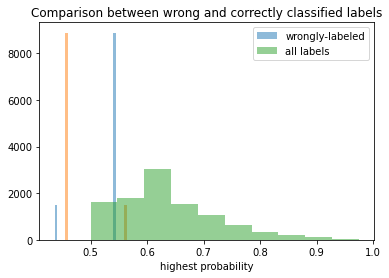

In [46]:
prediction_probs = model.predict_proba(x_test, batch_size=32, verbose=1)

wrong_probs = np.array([prediction_probs[ind][digit] for ind,digit in zip(wrong_results,predictions[wrong_results])])
all_probs =  np.array([prediction_probs[ind][digit] for ind,digit in zip(np.arange(len(predictions)),predictions)])
#plot as histogram
plt.hist(wrong_probs[0],alpha=0.5,label='wrongly-labeled');
plt.hist(all_probs,alpha=0.5,label='all labels');
plt.legend();
plt.title('Comparison between wrong and correctly classified labels');
plt.xlabel('highest probability');

In [45]:
pred = model.predict(x_test)

In [46]:
pred

array([[5.0350833e-01, 4.9649173e-01],
       [8.3788120e-07, 9.9999917e-01],
       [7.1380347e-02, 9.2861968e-01],
       ...,
       [6.1203009e-03, 9.9387968e-01],
       [9.9030566e-01, 9.6943537e-03],
       [4.4059697e-01, 5.5940306e-01]], dtype=float32)